#Code imports and data importation


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import seaborn as sns
import ast
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import h5py
import scipy
from tqdm import tqdm

In [ ]:
!mkdir "figures"
path = "figures/"

mkdir: cannot create directory ‘figures’: File exists


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
data1=pd.read_csv('/content/drive/My Drive/P3.1.csv',sep="\t")

In [ ]:
data2=pd.read_csv('/content/drive/My Drive/P3.2.csv',sep="\t")

In [ ]:
data1.shape

(3340, 47)

In [ ]:
data2.shape

(3376, 46)

In [ ]:
data1.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081


In [ ]:
data2.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,659000030,7,DOWNTOWN,47.6122,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.5,189.0,7226362.5,7456910.0,2003882.0,1156514.25,3946027.0,12764.5293,1276453.0,False,NaN,Compliant,NaN,249.98,2.83


#Data Cleaning

##Unify "Location" format




In [ ]:
def charToDict(chaine):
  d = ast.literal_eval(chaine)
  d["human_address"] = ast.literal_eval(d["human_address"])
  return d

In [ ]:
def decomposeLocation(data):
  locations = data["Location"]
  latitudes = np.array([charToDict(loc)["latitude"] for loc in locations]).astype(np.float64)
  longitudes = np.array([charToDict(loc)["latitude"] for loc in locations]).astype(np.float64)
  addresses = [charToDict(loc)["human_address"]["address"] for loc in locations]
  cities = [charToDict(loc)["human_address"]["city"] for loc in locations]
  states = [charToDict(loc)["human_address"]["state"] for loc in locations]
  zips = [charToDict(loc)["human_address"]["zip"] for loc in locations]
  return {"Latitude":latitudes,"Longitude":longitudes,"Address":addresses,"City":cities,"State":states,"ZipCode":zips}

In [ ]:
def insertLocations(data, data2):
  locationDict = decomposeLocation(data)
  i=0
  for key in locationDict.keys():
    data.insert(list(data2.columns).index(key), key, locationDict[key])
  return data

In [ ]:
insertLocations(data1, data2)
print(data1.shape)
data1.head(1)

(3340, 53)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,Latitude,Longitude,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,405 OLIVE WAY,SEATTLE,WA,98101,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,47.61219,47.61219,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081


In [ ]:
data1.rename(columns={'Comment': 'Comments', 'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions','GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity'}, inplace=True)

In [ ]:
Irrelevant1=['Location','OtherFuelUse(kBtu)','2010 Census Tracts','Seattle Police Department Micro Community Policing Plan Areas','City Council Districts','SPD Beats','Zip Codes']
#data1=data1.drop(Irrelevant1, axis=1)

In [ ]:
def dropIrrelevantFeatures(data, features):
  return data.drop(features, axis=1)

In [ ]:
dropIrrelevantFeatures(data1, Irrelevant1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,Latitude,Longitude,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,405 OLIVE WAY,SEATTLE,WA,98101,659000030,7,DOWNTOWN,1927,1,12.0,47.612190,47.612190,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,249.43,2.64,No,NaN,Compliant,NaN
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,724 PINE ST,SEATTLE,WA,98101,659000220,7,DOWNTOWN,1996,1,11.0,47.613106,47.613106,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,263.51,2.38,No,NaN,Compliant,NaN
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,1900 5TH AVE,SEATTLE,WA,98101,659000475,7,DOWNTOWN,1969,1,41.0,47.613349,47.613349,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,2061.48,1.92,Yes,NaN,Compliant,NaN
3,5,2015,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,SEATTLE,WA,98101,659000640,7,DOWNTOWN,1926,1,10.0,47.614216,47.614216,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,1936.34,31.38,No,NaN,Compliant,High Outlier
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,401 LENORA ST,SEATTLE,WA,98121,659000970,7,DOWNTOWN,1980,1,18.0,47.613754,47.613754,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,507.70,4.02,No,NaN,Compliant,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,50049,2015,Multifamily LR (1-4),Low-Rise Multifamily,PACIFIC CENTER CONDOMINIUM,321 10TH AVE S,SEATTLE,WA,98104,6599950000,2,DOWNTOWN,2000,1,4.0,47.599503,47.599503,44650,0,44650,Multifamily Housing,Multifamily Housing,44650.0,NaN,NaN,NaN,NaN,NaN,71.0,25.6,27.8,80.4,87.2,1142949.0,1240429.0,0.0,334979.0,1142996.0,0.0,0.0,7.97,0.07,No,NaN,Compliant,NaN
3336,50055,2015,Multifamily MR (5-9),Mid-Rise Multifamily,IDENTITY APTS 4123,4123 12TH AVE NE,SEATTLE,WA,98105,1142001670,4,NORTHEAST,2014,1,7.0,47.657525,47.657525,42393,0,42393,Multifamily Housing,Multifamily Housing,31748.0,NaN,NaN,NaN,NaN,NaN,98.0,48.6,55.1,124.2,144.7,1543282.0,1750143.0,0.0,325705.0,1111352.0,4320.0,431976.0,30.69,0.61,No,NaN,Compliant,NaN
3337,50057,2015,Multifamily HR (10+),High-Rise Multifamily,CIRRUS,2030 8TH AVE,SEATTLE,WA,98121,660000575,7,DOWNTOWN,2015,1,40.0,47.616498,47.616498,319481,41915,277566,"Multifamily Housing, Parking",NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,52.7,61.4,93.1,102.2,16834414.0,19623362.0,0.0,1690364.0,5767761.0,110669.0,11066893.0,627.97,1.89,No,NaN,Compliant,NaN
3338,50058,2015,Multifamily LR (1-4),Low-Rise Multifamily,WEDGEWOOD ESTATES BLDG A,3801 NE 77TH ST,SEATTLE,WA,98115,6392001040,4,NORTHEAST,1981,1,3.0,47.683970,47.683970,48230,0,48230,Multifamily Housing,Multif

In [ ]:
def Rename_variables(data, old_variable, new_variable):
  print(list(data.columns))
  data.insert(list(data.columns).index(old_variable), new_variable, data[old_variable])
  data_rename=data.drop([old_variable], axis=1)
  return data_rename

In [ ]:
#Rename_variables(data1, 'Comment', 'Comments')
#print(data_rename.head(1))

In [ ]:
frames=[data1,data2]
data_mix=pd.concat(frames)

In [ ]:
print(data_mix.shape)
data_mix = data_mix.drop(["Location"], axis=1)
data_mix.head(1)

(6716, 53)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,Latitude,Longitude,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,405 OLIVE WAY,SEATTLE,WA,98101,659000030,7,DOWNTOWN,1927,1.0,12.0,47.61219,47.61219,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081.0


##Remove NAN Values

In [ ]:
def graph_taux_de_remplissage(data,rate=0.8):
  taux_de_remplissage = calculateFillRate(data)
  nbr_columns = len(data.columns)
  x = np.linspace(0, nbr_columns, nbr_columns)
  y = taux_de_remplissage
  z = [rate*100 for i in range(nbr_columns)]
  plt.figure(figsize=(20,6))
  plt.scatter(x,y)
  plt.plot(x,z, color='red')
  plt.show()

In [ ]:
def calculateFillRate(data):
  nbr_rows = len(data.index)
  nbr_columns = len(data.columns)
  fillRate = []
  for column in data.columns:
    fillRate.append(100 * (nbr_rows - data[column].isna().sum()) / nbr_rows)
  return fillRate

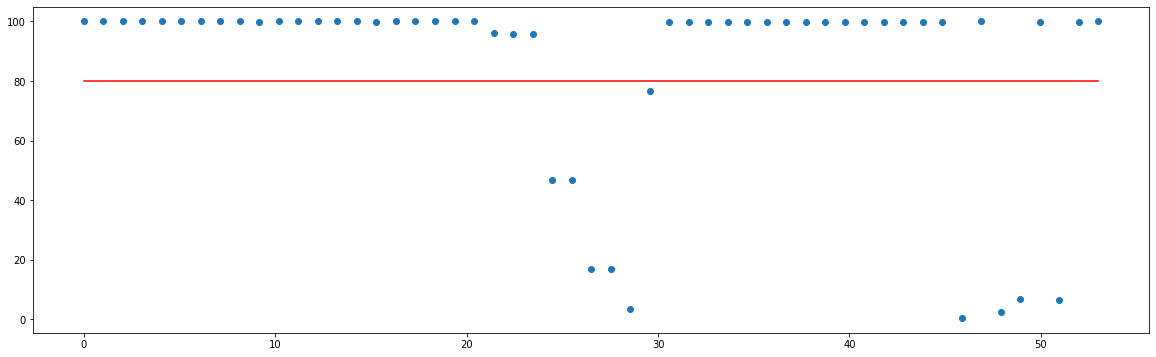

In [ ]:
graph_taux_de_remplissage(data1)

In [ ]:
compteur=0
for colonne1 in data1.columns:
  compteur=0
  for colonne2 in data2.columns:
    if colonne1==colonne2:
      compteur+=1
      compteur+=1
  if compteur==0:
    print(colonne1)

print('\n')
print(compteur)
print('\n')

for colonne2 in data2.columns:
  compteur=0
  for colonne1 in data1.columns:
    if colonne1==colonne2:
      compteur+=1
  if compteur==0:
    print(colonne2)

Location
OtherFuelUse(kBtu)
2010 Census Tracts
Seattle Police Department Micro Community Policing Plan Areas
City Council Districts
SPD Beats
Zip Codes


0




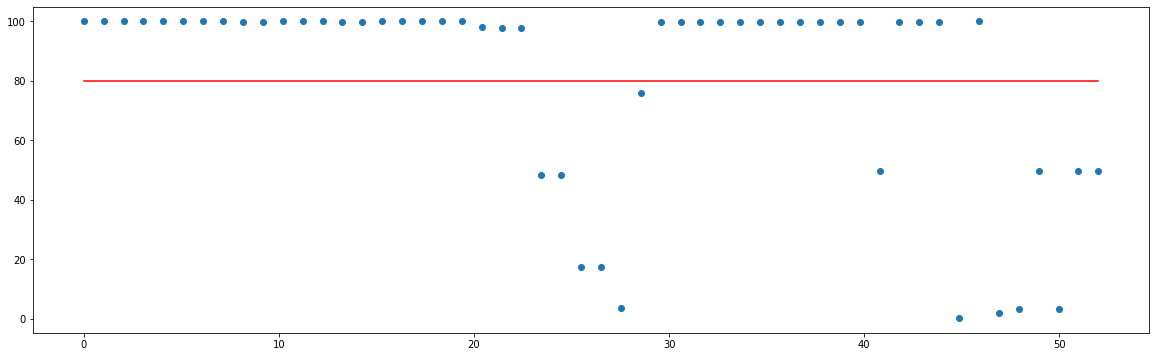

In [ ]:
graph_taux_de_remplissage(data_mix)

In [ ]:
plt.savefig(path+ "taux_de_remplissage.png")

<Figure size 432x288 with 0 Axes>

In [ ]:
def Features_under_the_rate(data,rate=0.8):
  Features_under_the_rate=[]
  nbr_rows = len(data.index)
  nbr_columns = len(data.columns)
  for column in data.columns:
    if 100*(nbr_rows-data[column].isna().sum()) / nbr_rows<rate*100:
      Features_under_the_rate.append(column)
  return Features_under_the_rate

Features_under_the_rate(data_mix,rate=0.7)

['SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'OtherFuelUse(kBtu)',
 'Comments',
 'Outlier',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes']

In [ ]:
data_mix=data_mix.drop(Features_under_the_rate(data_mix,rate=0.7), axis=1)

In [ ]:
print(data_mix.shape)
data_mix.head(1)

(6716, 39)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,Latitude,Longitude,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,ComplianceStatus
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,405 OLIVE WAY,SEATTLE,WA,98101,659000030,7,DOWNTOWN,1927,1.0,12.0,47.61219,47.61219,88434,0,88434,Hotel,Hotel,88434.0,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,249.43,2.64,No,Compliant


In [ ]:
Irrelevant2=['Address','City','State','OSEBuildingID','DataYear','PropertyName','TaxParcelIdentificationNumber','ZipCode','LargestPropertyUseType','DefaultData','ComplianceStatus']
#'CouncilDistrictCode','Neighborhood','ListOfAllPropertyUseTypes'
len(Irrelevant2)

11

In [ ]:
data_test=data_mix.drop(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'GHGEmissionsIntensity', 'DefaultData',
       'ComplianceStatus'],axis=1)
correl_1=data_test.sample(frac=00.1).corr(method='pearson')
print(correl_1)

                   Latitude  Longitude  TotalGHGEmissions
Latitude           1.000000   0.023498          -0.015170
Longitude          0.023498   1.000000           0.009544
TotalGHGEmissions -0.015170   0.009544           1.000000


In [ ]:
data_mix = data_mix.drop(Irrelevant2, axis=1)
data_mix.shape

(6716, 28)

##Remove Outliers

In [ ]:
#stat=[]
#for var in variable_quanti:
 # k=[]
 # k.append(data_mix[var].quantile(0.25))
 # k.append(data_mix[var].quantile(0.75))
 # k.append(k[1]-k[0])
  #stat.append(k)
def outlier(var,data):
  outlier_base=[]
  for i in data[var]:
    if i<stat[compteur_stat][0]-1.5*stat[compteur_stat][2] or i>stat[compteur_stat][1]+1.5*stat[compteur_stat][2]:
      outlier_base.append(i)
  return outlier_base
#compteur_stat=0
#for var in variable_quanti:
  #print(len(outlier(var,data_mix)))
  #compteur_stat+=1 

In [ ]:
def outlier_ENERGYSTARScore(data):
  for value in data_mix['ENERGYSTARScore']:
    if value<0 or value>100:
      print(value)

outlier_ENERGYSTARScore(data_mix)

#Data visualization

###Univariate data visualization

In [ ]:
print(data_mix.columns)
len(data_mix.columns)

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'Latitude', 'Longitude', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')


28

In [ ]:
variable_quanti=['GHGEmissionsIntensity','TotalGHGEmissions','PropertyGFATotal','SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)','Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)','YearBuilt','NumberofBuildings','NumberofFloors','PropertyGFAParking','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA','ENERGYSTARScore']
len(variable_quanti)

20

In [ ]:
variable_quali=['BuildingType', 'PrimaryPropertyType']

In [ ]:
for colonne1 in data_mix.columns:
  compteur=0
  for colonne2 in variable_quanti:
    if colonne1==colonne2:
      compteur+=1
  if compteur==0:
    print(colonne1)

BuildingType
PrimaryPropertyType
CouncilDistrictCode
Neighborhood
Latitude
Longitude
ListOfAllPropertyUseTypes
SiteEnergyUse(kBtu)


BuildingType: 



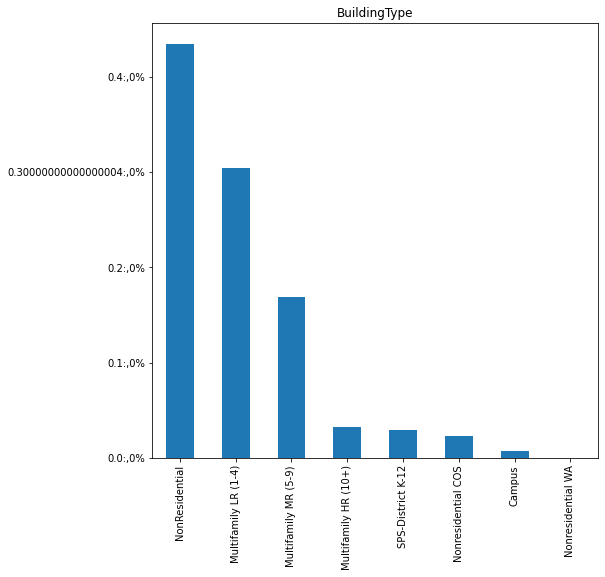

PrimaryPropertyType: 



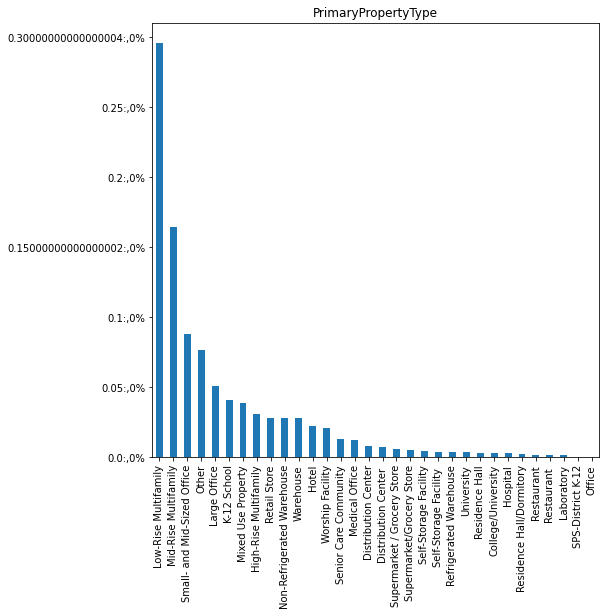

In [ ]:
for var in variable_quali:
  print(var+': \n')
  fig,ax=plt.subplots(figsize=(8,8))
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: '{}:,0%'.format(x)))
  data_mix[var].value_counts(normalize=True).plot(kind='bar')
  plt.title(var)
  plt.show()

In [ ]:
plt.savefig(path+ "variable_quali.png")

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


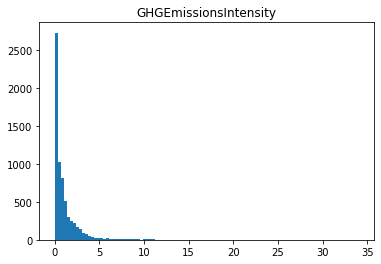

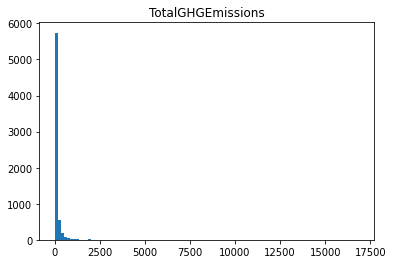

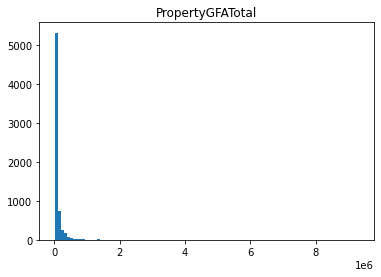

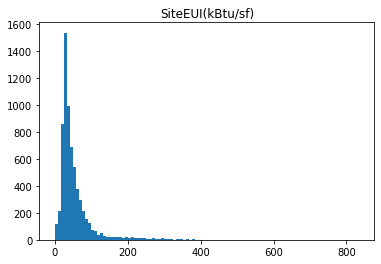

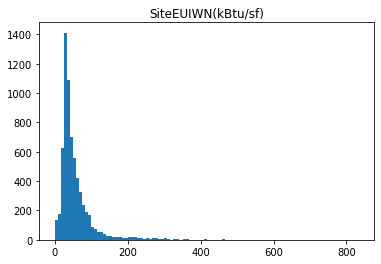

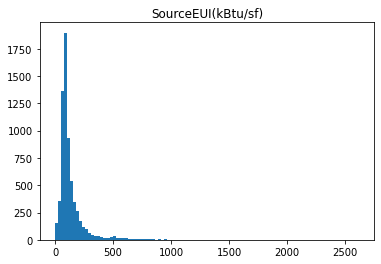

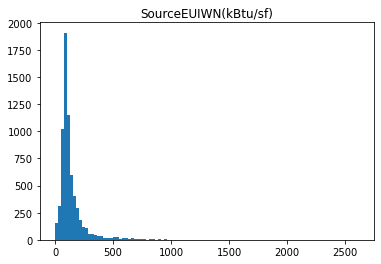

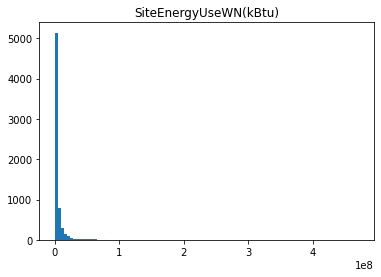

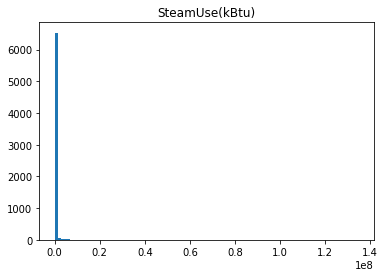

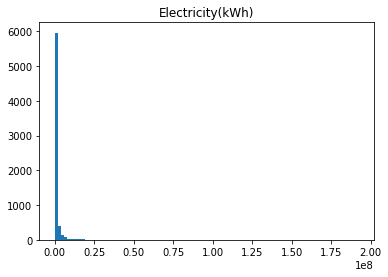

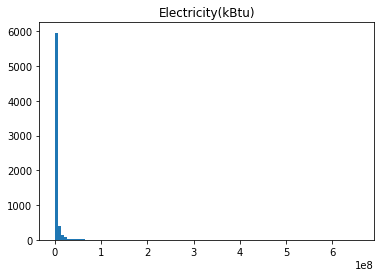

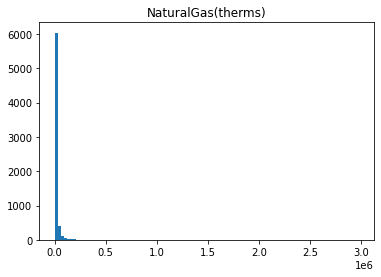

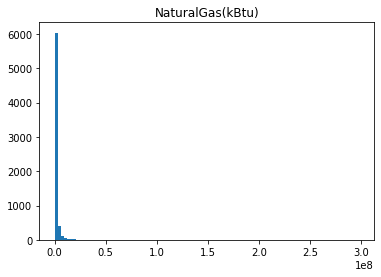

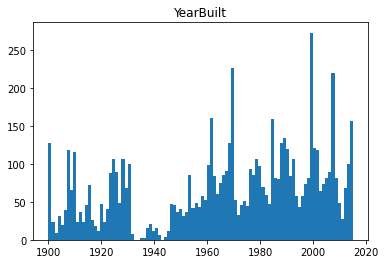

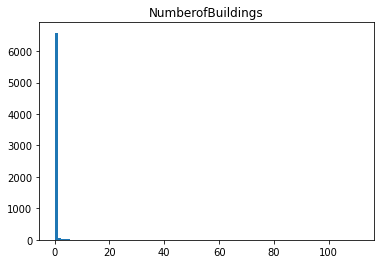

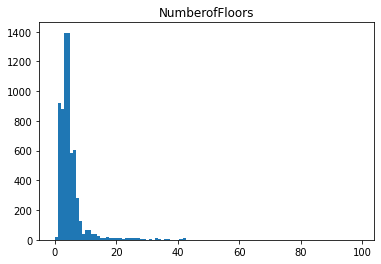

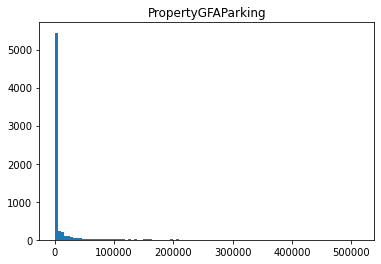

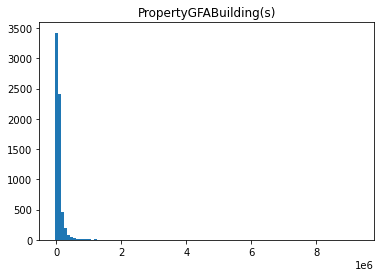

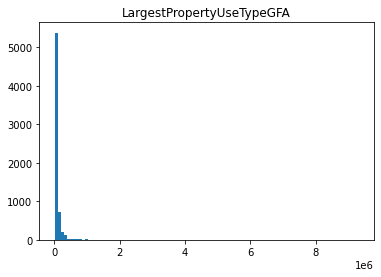

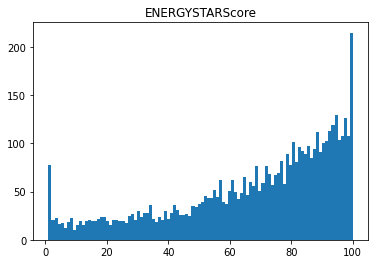

In [ ]:
def graph_quanti(var):
  fig1,ax1=plt.subplots()
  ax1.set_title(var)
  plt.hist(data_mix[var],bins=100)
for var in variable_quanti:
  graph_quanti(var)

In [ ]:
plt.savefig(path+ "variable_quanti.png")

<Figure size 432x288 with 0 Axes>

##Multivariate Analysis

In [ ]:
#sample=np.random.randint(data_mix.shape[0],size=int(data_mix.shape[0]*0.1))
#df_sample=data_mix.iloc[sample]
#sns.pairplot(df_sample,vars=variable_quanti)

Text(0.0, 1.0, 'Heatmap des indicateurs numériques\n')

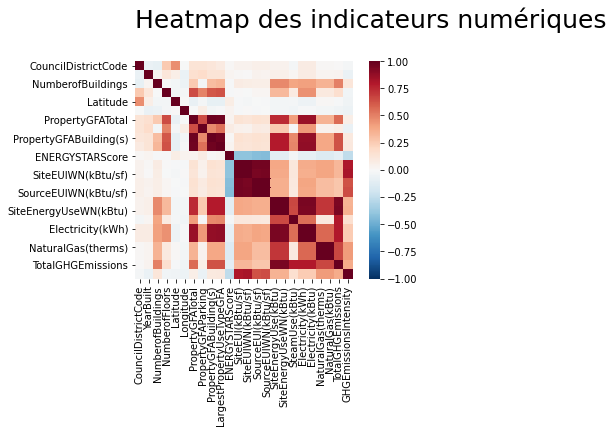

In [ ]:
correl=data_mix.sample(frac=00.1).corr(method='pearson')
correl_final=sns.heatmap(correl,vmin=-1,vmax=1,center=0,cmap="RdBu_r",square=True)
correl_final.set_title('Heatmap des indicateurs numériques\n',fontsize=25,loc='left')

In [ ]:
plt.savefig(path+ "heatmap.png")

<Figure size 432x288 with 0 Axes>

Grâce au Heatmap on remarque les variables:
- NumberofBuildings, PropertyGFATotal, PropertyGFABuilding(s),LargestPropertyUseTypeGFA
-SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf)
-SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf)
-Electricity(kWh), Electricity(kBtu)
-NaturalGas(therms), NaturalGas(kBtu)

sont corrélés entre-elles, il est donc inutile de garder ces variables car on ne pert pas d'information en n'en gardant qu'une des deux variables. 
Supprimons donc les variables :

PropertyGFATotal, PropertyGFABuilding(s),LargestPropertyUseTypeGFA, SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf), Electricity(kBtu),NaturalGas(kBtu)


In [ ]:
#'PropertyGFABuilding(s)'
#'GHGEmissionsIntensity',,'SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)'
Irrelevant3=['LargestPropertyUseTypeGFA','SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)','Electricity(kBtu)','NaturalGas(therms)', 'NaturalGas(kBtu)', 'SiteEnergyUseWN(kBtu)']
#variable_quanti=[var in variable_quanti if var not in Irrelevant3]
variable_quanti2=[]
for var in variable_quanti:
  if var not in Irrelevant3:
    variable_quanti2.append(var)
print(variable_quanti2)
len(variable_quanti2)

['GHGEmissionsIntensity', 'TotalGHGEmissions', 'SiteEUI(kBtu/sf)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ENERGYSTARScore']


11

In [ ]:
data_mix=data_mix.drop(Irrelevant3, axis=1)
data_mix.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

Text(0.0, 1.0, 'Heatmap des indicateurs numériques\n')

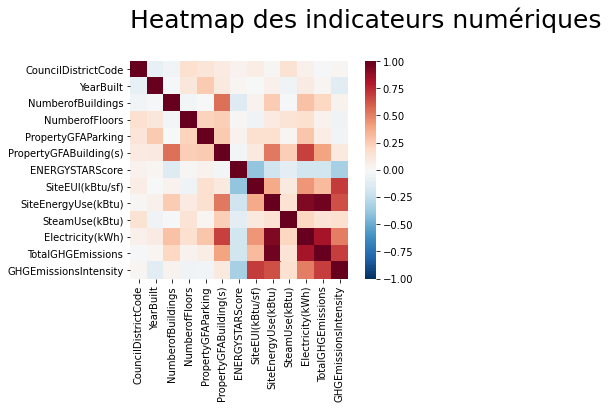

In [ ]:
correl=data_mix.sample(frac=00.1).corr(method='pearson')
correl_final=sns.heatmap(correl,vmin=-1,vmax=1,center=0,cmap="RdBu_r",square=True)
correl_final.set_title('Heatmap des indicateurs numériques\n',fontsize=25,loc='left')
#SteEnergyUse(kBtu), NaturalGas(therms), 

In [ ]:
correl.head(10)

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),TotalGHGEmissions,GHGEmissionsIntensity
CouncilDistrictCode,1.000000,-0.078879,-0.038957,0.162937,0.128573,0.087085,0.040301,0.076782,0.007879,0.140649,0.052879,-0.014565,0.017547
YearBuilt,-0.078879,1.000000,-0.014881,0.115477,0.258068,0.101561,0.016646,-0.002358,0.049492,-0.042054,0.085919,0.021934,-0.111212
NumberofBuildings,-0.038957,-0.014881,1.000000,-0.024402,-0.001098,0.547486,-0.128813,0.046369,0.250189,-0.009486,0.292997,0.206054,0.037494
NumberofFloors,0.162937,0.115477,-0.024402,1.000000,0.230432,0.248861,0.011583,-0.040639,0.091627,0.132868,0.162950,0.046380,-0.044029
PropertyGFAParking,0.128573,0.258068,-0.001098,0.230432,1.000000,0.259393,0.044958,0.161840,0.159069,0.021011,0.281067,0.073755,-0.031794
PropertyGFABuilding(s),0.087085,0.101561,0.547486,0.248861,0.259393,1.000000,-0.026403,0.098444,0.527945,0.244461,0.684224,0.404172,0.100031
ENERGYSTARScore,0.040301,0.016646,-0.128813,0.011583,0.044958,-0.026403,1.000000,-0.396320,-0.196269,-0.108541,-0.191840,-0.188327,-0.331873
SiteEUI(kBtu/sf),0.076782,-0.002358,0.046369,-0.040639,0.161840,0.098444,-0.396320,1.000000,0.381521,0.098301,0.443355,0.320139,0.698216
SiteEnergyUse(kBtu),0.007879,0.049492,0.250189,0.091627,0.159069,0.527945,-0.196269,0.381521,1.000000,0.148625,0.933451,0.976424,0.647917
SteamUse(kBtu),0.140649,-0.042054,-0.009486,0.132868,0.021011,0.244461,-0.108541,0.098301,0.148625,1.000000,0.214928,0.134408,0.162125


In [ ]:
L=[]
liste_var_corr=[]
for colonne in correl.columns:
  L.append(colonne)
  
for colonne in correl.columns: 
  compteur_ligne=0
  for value in correl[colonne]:
    k=[]
    if (value<-0.5 or value>0.5) and value!=1:
      k.append(colonne)
      k.append(L[compteur_ligne])
      k.append(value)
      liste_var_corr.append(k)
    compteur_ligne+=1
liste_var_corr

[['NumberofBuildings', 'PropertyGFABuilding(s)', 0.5474858965813894],
 ['PropertyGFABuilding(s)', 'NumberofBuildings', 0.5474858965813894],
 ['PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)', 0.5279454959641956],
 ['PropertyGFABuilding(s)', 'Electricity(kWh)', 0.6842236500487142],
 ['SiteEUI(kBtu/sf)', 'GHGEmissionsIntensity', 0.6982160416669154],
 ['SiteEnergyUse(kBtu)', 'PropertyGFABuilding(s)', 0.5279454959641956],
 ['SiteEnergyUse(kBtu)', 'Electricity(kWh)', 0.9334513010825245],
 ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 0.9764240078178826],
 ['SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity', 0.6479174659560101],
 ['Electricity(kWh)', 'PropertyGFABuilding(s)', 0.6842236500487142],
 ['Electricity(kWh)', 'SiteEnergyUse(kBtu)', 0.9334513010825245],
 ['Electricity(kWh)', 'TotalGHGEmissions', 0.8352403314013112],
 ['Electricity(kWh)', 'GHGEmissionsIntensity', 0.5079892738479225],
 ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)', 0.9764240078178826],
 ['TotalGHGEmissions', 'Electricity(kWh)'

In [ ]:
_d = ['CouncilDistrictCode','YearBuilt','NumberofBuildings','NumberofFloors','PropertyGFAParking','PropertyGFABuilding(s)']

In [ ]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique()[1:]:
        #yi_classe = y[x==classe]
        yi_classe = []
        existList = x==classe 
        for i, val in enumerate(existList):
          if val: yi_classe.append(y[i])
        yi_classe = pd.Series(yi_classe)
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return np.sqrt(SCE/SCT)

In [ ]:
X = data_mix["BuildingType"]
Y = data_mix["Electricity(kWh)"]
X = X[~X.isna()]
Y = Y[~Y.isna()]
X = X[:min(X.shape[0], Y.shape[0])]
Y = Y[:min(X.shape[0], Y.shape[0])]
X = X.reset_index()
Y = Y.reset_index()
X = X.drop(["index"], axis=1)
Y = Y.drop(["index"], axis=1)
X = X["BuildingType"]
Y = Y["Electricity(kWh)"]

In [ ]:
print("R2: ", eta_squared(X, Y))

R2:  0.1009777087374763


In [ ]:
data_mix.to_csv("data_mix.csv", index=False)

In [ ]:
data_mix_test = pd.read_csv("data_mix.csv")
data_mix_test.head()

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),TotalGHGEmissions,GHGEmissionsIntensity
0,NonResidential,Hotel,7,DOWNTOWN,1927,1.0,12.0,0,88434,Hotel,65.0,78.9,6981428.0,2023032.0,1080307.0,249.43,2.64
1,NonResidential,Hotel,7,DOWNTOWN,1996,1.0,11.0,15064,88502,"Hotel, Parking, Restaurant",51.0,94.4,8354235.0,0.0,1144563.0,263.51,2.38
2,NonResidential,Hotel,7,DOWNTOWN,1969,1.0,41.0,0,961990,"Hotel, Parking, Swimming Pool",18.0,96.6,73130656.0,19660404.0,14583930.0,2061.48,1.92
3,NonResidential,Hotel,7,DOWNTOWN,1926,1.0,10.0,0,61320,Hotel,1.0,460.4,28229320.0,23458518.0,811521.0,1936.34,31.38
4,NonResidential,Hotel,7,DOWNTOWN,1980,1.0,18.0,12460,107430,"Hotel, Parking, Swimming Pool",67.0,120.1,14829099.0,0.0,1777841.0,507.70,4.02


In [ ]:
data_mix=data_mix[data_mix['BuildingType']=='NonResidential']

In [ ]:
print(data_mix.shape)

(2921, 17)


In [ ]:
!cp "data_mix_nonresidential.csv" "drive/My Drive/"

cp: cannot stat 'data_mix_nonresidential.csv': No such file or directory


In [ ]:
data_mix.to_csv("drive/My Drive/data_mix_without_residential.csv", index=False)

In [ ]:
data_mix.shape

(2921, 17)

In [ ]:
!zip -r "figures.zip" "figures"

  adding: figures/ (stored 0%)
  adding: figures/variable_quali.png (deflated 83%)
  adding: figures/heatmap.png (deflated 83%)
  adding: figures/variable_quanti.png (deflated 83%)
  adding: figures/taux_de_remplissage.png (deflated 83%)
